# Option Greeks

Learning about greeks by recreating graphs from chapter 8 of "Option Volatility and Pricing" by Sheldon Natenburg

In [41]:
# Imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

## Black-Scholes Model

For European calls and puts

In [42]:
def black_scholes(sigma, K, r, S0, T,is_call=True, d=0):
    d1 = (math.log(S0 / K) + (r - d + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if is_call:
        price = S0 * norm.cdf(d1) * math.exp(-d * T) - K * math.exp(-r * T) * norm.cdf(d2)
        return float(price)
    else:
        price =  K * math.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1) * math.exp(-d * T)
        return float(price)

In [43]:
sigma = 0.2  # Annualized volatility
K = 100  # Strike
r = 0.06  # Risk-free rate (annual)
T = 0.5  # Time period (pct of year)
S0 = 100 # Stock price at start of contract

black_scholes(sigma, K, r, S0, T)

7.155896056109235

Checking against an online calculator, this is correct.

Now checking call & put values across different strikes to make sure everything looks right

In [44]:
def graph_call_put(E_start, E_end, res):
    n_steps = int((E_end - E_start) / res) + 1
    option_values = np.zeros((3, n_steps))
    
    for i in range(n_steps): 
        K = i * res + E_start
        option_values[0, i] = K
        call = black_scholes(sigma, K, r, S0, T,is_call=True, d=0)
        put = black_scholes(sigma, K, r, S0, T,is_call=False, d=0)
        option_values[1, i] = call
        option_values[2, i] = put
        
    plt.title("Option Value by Exercise Price")
    plt.xlabel("Exercise Price")
    plt.plot(option_values[0], option_values[1])
    plt.plot(option_values[0], option_values[2])
    plt.legend(["Call", "Put"])
    plt.show()

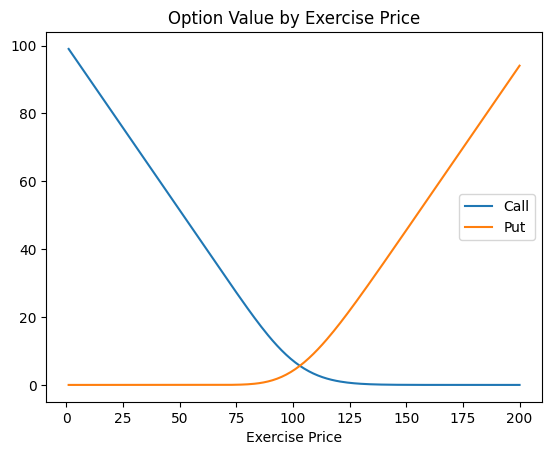

In [45]:
graph_call_put(1,200,1)

## The Greeks

Looking at delta, gamma, theta, and vega (sorry rho) for European options

First lets alter our Black-Scholes function to return these values

In [46]:
def black_scholes_greeks(sigma, K, r, S0, T,is_call=True, d=0):
    d1 = (math.log(S0 / K) + (r - d + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    # Gamma and vega are the same for calls and puts
    gamma = norm.pdf(d1) / (S0 * sigma * math.sqrt(T))
    vega = S0 * norm.pdf(d1) * math.sqrt(T)
    
    if is_call:
        delta = norm.cdf(d1)
        theta = -(S0 * norm.pdf(d1) * sigma/(2 * math.sqrt(T))) - r * K * math.exp(-r * T) * norm.cdf(d2)
        price = S0 * norm.cdf(d1) * math.exp(-d * T) - K * math.exp(-r * T) * norm.cdf(d2)
        return float(price), float(delta), float(gamma), float(vega), float(theta)
    else:
        delta = norm.cdf(d1) - 1
        theta = -(S0 * norm.pdf(d1) * sigma/(2 * math.sqrt(T))) + r * K * math.exp(-r * T) * norm.cdf(-d2)
        price =  K * math.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1) * math.exp(-d * T)
        return float(price), float(delta), float(gamma), float(vega), float(theta)

In [47]:
sigma = 0.2  # Annualized Volatility
K = 100  # Strike
r = 0.06  # Risk-Free rate (annual)
T = 0.5  # Time period (pct of year)
S0 = 100 # Stock price at start of contract

black_scholes_greeks(sigma, K, r, S0, T,is_call=True)

(7.155896056109235,
 0.6113512946052392,
 0.02710336967762158,
 27.103369677621583,
 -8.659427939789197)

Once again, everything looks right

### Graphing function

First a function to graph any of the Greeks (or price) against S0, T, or volatility

In [48]:
def greek_underlying(sigma, K_list, r, T, S0, start, stop, step, calls=True, greek='delta', y='underlying'):
    greek_dict = {'price': 0, 'delta': 1, 'gamma': 2, 'vega': 3, 'theta': 4}
    x_range = np.linspace(start, stop, int(stop/step))
    delta_array = np.zeros((4, int(stop/step))) # underlying, OTM K, ATM K, ITM K
    
    for i in range(int(stop/step)):
        if y == 'T':
            T = x_range[i]
            delta_array[0, i] = T
        elif y == 'sigma':
            sigma = x_range[i]
            delta_array[0, i] = sigma
        else:
            S0 = x_range[i]
            delta_array[0, i] = S0
        
        delta_array[1, i] = black_scholes_greeks(sigma, K_list[0], r, S0, T,is_call=calls)[greek_dict[greek]]
        delta_array[2, i] = black_scholes_greeks(sigma, K_list[1], r, S0, T,is_call=calls)[greek_dict[greek]]
        delta_array[3, i] = black_scholes_greeks(sigma, K_list[2], r, S0, T,is_call=calls)[greek_dict[greek]]
        
    plt.plot(delta_array[0], delta_array[1])
    plt.plot(delta_array[0], delta_array[2])
    plt.plot(delta_array[0], delta_array[3])
    plt.title(f"{greek} by {y}")
    plt.xlabel(f"{y}")
    plt.ylabel(f"{greek}")
    plt.legend([f"K={K_list[0]}", f"K={K_list[1]}", f"K={K_list[2]}"])
    plt.show()

## Delta

The change in value of an option for the change in the underlying

Let's see how this changes as the underlying price changes 

For calls:

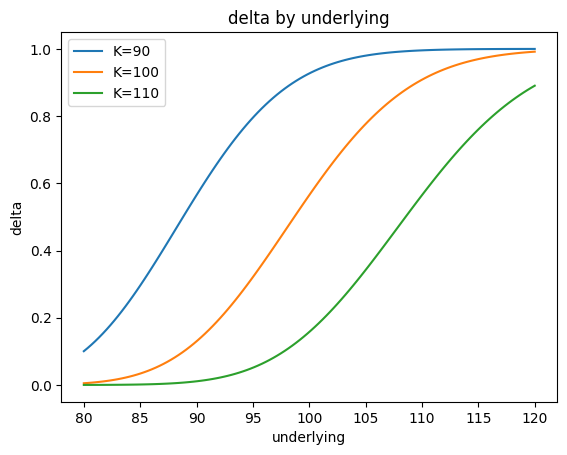

In [49]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 80, 120, 1, calls=True)

For puts:

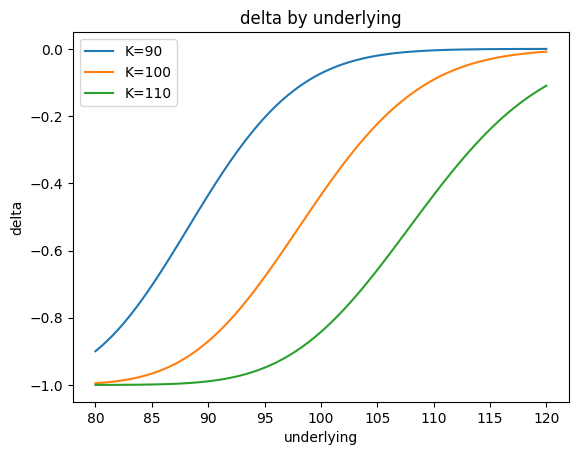

In [50]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 80, 120, 1, calls=False)

What does this tell us?

For call options:
Delta approaches 0 as it goes further out of the money and 1 as it goes further into the money.
An option that is very far out of the money is unlikely to expire with any value, so the stock going up or down some won't change much.
Similarly, an option very deep in the money is going to move dollar for dollar with the underlying as it will likely expire in the money.

For put options everything is similar, but negative. The delta can be thought of the equivalent position in the underlying. The underlying has a delta of 1 (dS/dS), and a put is a sort of short position in the underlying, so it makes sense it is always negative. 

The delta can also be thought of as an approximation of the probability that an option finishes in the money (multiply a put's delta by -1). The deltas around the strike are ~0.5, implying that it's close the equally likely to expire OTM or ITM.

## Gamma

The rate of change in delta for change in the underlying

Here's gamma versus the underlying for calls:

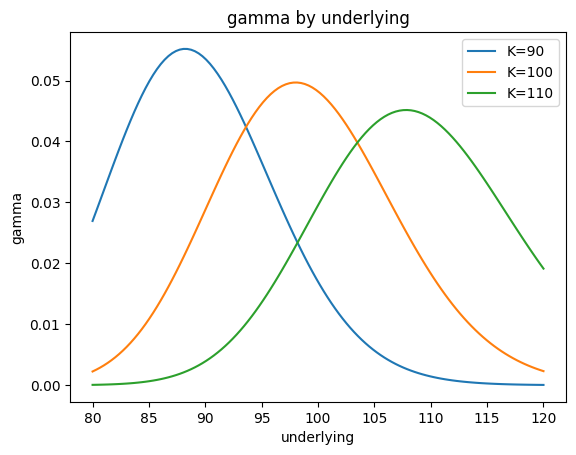

In [51]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 80, 120, 1, calls=True, greek='gamma')

And puts:

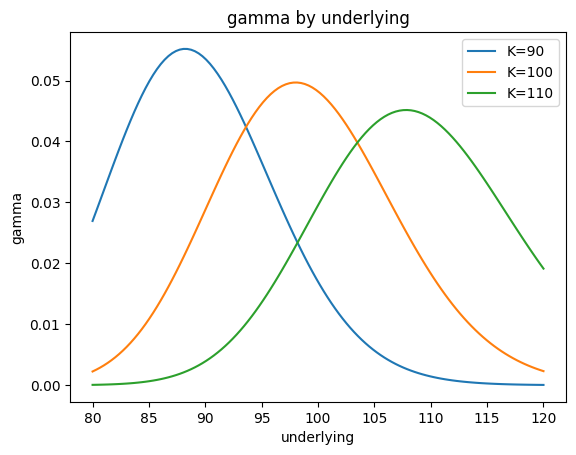

In [52]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 80, 120, 1, calls=False, greek='gamma')

They're both positive and the same! (non-zero rates can cause slight differences)

For a put, this is because an upward movement in the underlying means delta increases, but because the delta is negative, it is increasing to 0. 

A higher gamma position is riskier because a position's relationship to the underlying changes quicker.

Now let's see gamma as time to expiration changes

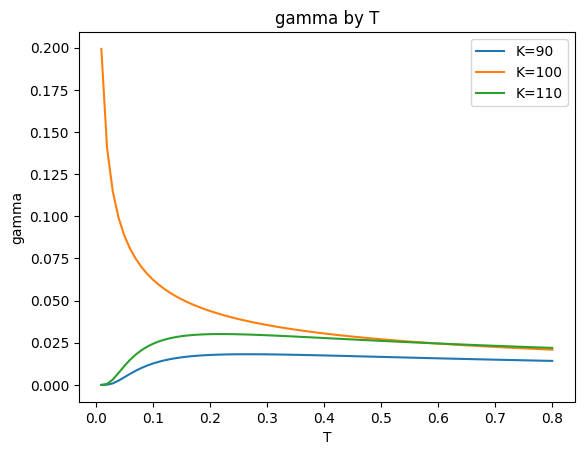

In [53]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 0.01, 0.8, 0.01, calls=False, greek='gamma', y='T')

Here we see that gamma is generally low, but explodes closer to expiration if it close to ATM and otherwise goes to 0

Now let's do it for vol: 

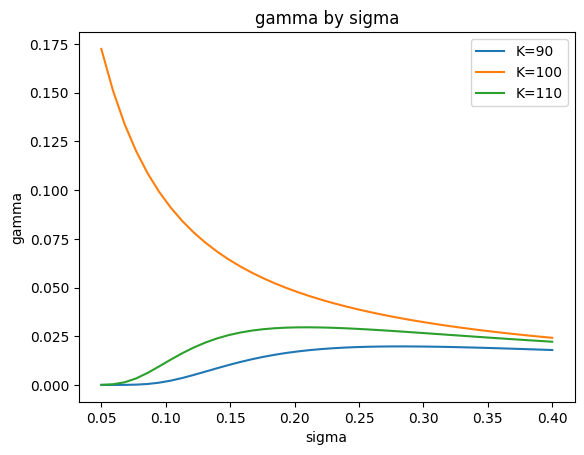

In [54]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 0.05, 0.4, 0.01, calls=True, greek='gamma', y='sigma')

Similarly, gamma explodes as vol approaches 0 for an ATM option. I didn't get this at first, but it's because gamma becomes more and more concentrated around the strike as vol decreases, and each move around the strike is very meaningful.

Here is the gamma versus underlying graph from above but with 5% vol instead of 20% vol, and you can see the concentration:

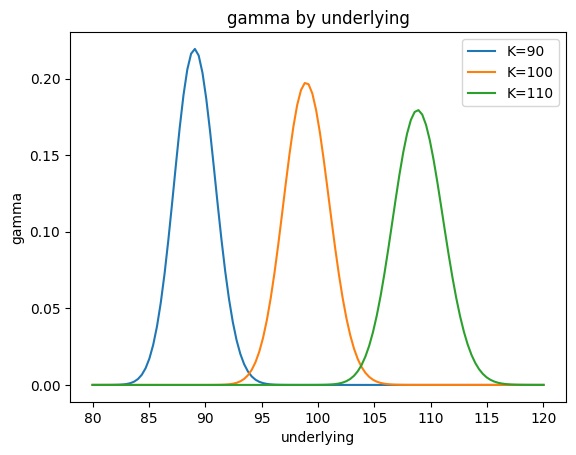

In [55]:
greek_underlying(0.05, [90,100,110], 0.06, 0.1667, 100, 80, 120, 1, calls=True, greek='gamma')

## Theta

The change in price over the change in time

Note that theta is almost always negative as the passing of time gives less opportunity for the option to expire in the money (or more in the money). This is referred to as decay. 

I think it is useful to first look at the price versus the underlying for options with various times until expiration (all else being equal) to see this.

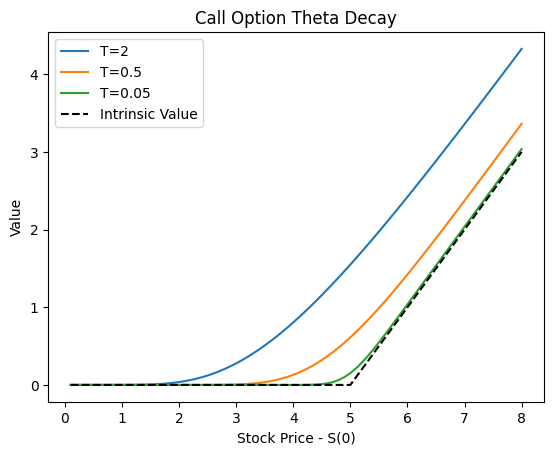

In [56]:
def intrinsic_value(S, K, is_call=True):
    if is_call:
        return np.maximum(S - K, 0)
    else:
        return np.maximum(K - S, 0)

def theta_decay(sigma, K, r, start, stop, step, calls=True):
    S0_range = np.linspace(start, stop, int(stop/step))
    
    price_by_S0 = np.zeros((5, int(stop/step)))
    # row 1 is S0, 2 is American price, 3 is Euro price, 4 is intrinsic value
    for i in range(int(stop/step)):
        S0 = S0_range[i]
        price_by_S0[0, i] = S0
        price_by_S0[1, i] = black_scholes_greeks(sigma, K, r, S0, 2, is_call=calls)[0]
        price_by_S0[2, i] = black_scholes_greeks(sigma, K, r, S0, 0.5, is_call=calls)[0]
        price_by_S0[3, i] = black_scholes_greeks(sigma, K, r, S0, 0.05, is_call=calls)[0]
        price_by_S0[4, i] = intrinsic_value(S0,K,calls)

    plt.plot(price_by_S0[0], price_by_S0[1])
    plt.plot(price_by_S0[0], price_by_S0[2])
    plt.plot(price_by_S0[0], price_by_S0[3])
    plt.plot(price_by_S0[0], price_by_S0[4], 'k--')
    plt.title("Call Option Theta Decay")
    plt.xlabel("Stock Price - S(0)")
    plt.ylabel("Value")
    plt.legend(["T=2", "T=0.5", "T=0.05", "Intrinsic Value"])
    plt.show()
    
theta_decay(0.3, 5, 0.15, 0.1, 8, 0.1)

A large (magnitude) theta corresponds with a large gamma. The next couple of graphs show this inverse relationship Theta and Gamma:

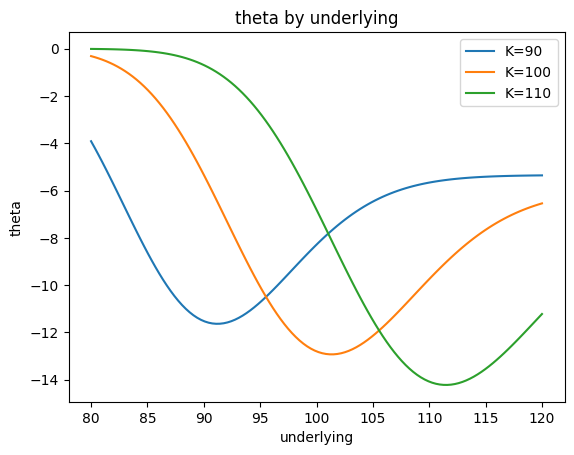

In [57]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 80, 120, 1, calls=True, greek='theta')

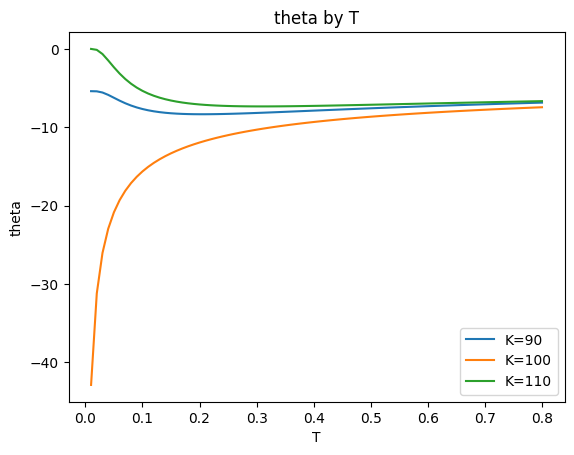

In [58]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 0.01, 0.8, 0.01, calls=True, greek='theta', y='T')

## Vega 

The sensitivity of the option price to volatility

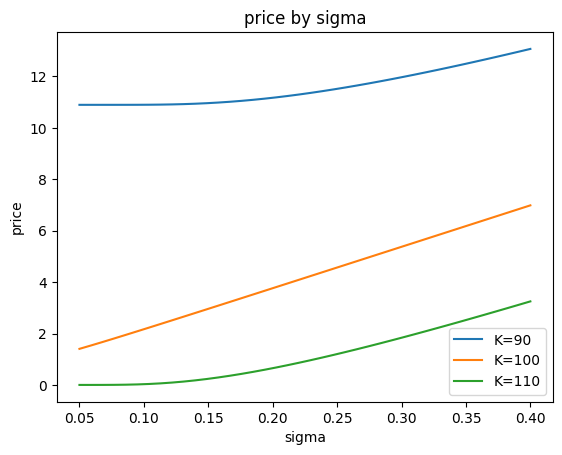

In [59]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 0.05, 0.4, 0.01, calls=True, greek='price', y='sigma')

Here we see higher volatility increases the value of a call option at each strike, as the range of possible final values the stock can be is more spread out. 

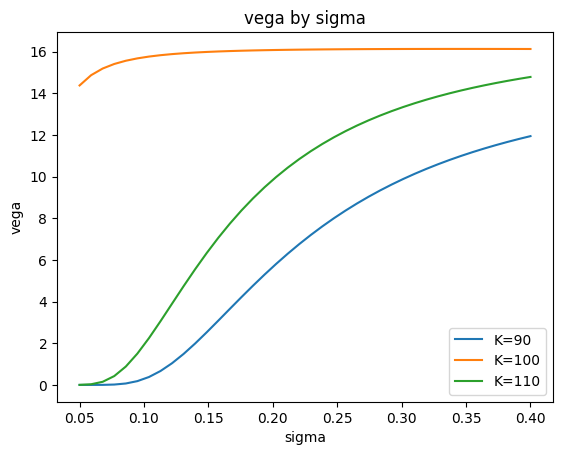

In [60]:
greek_underlying(0.2, [90,100,110], 0.06, 0.1667, 100, 0.05, 0.4, 0.01, calls=True, greek='vega', y='sigma')

Here we see that an ATM strike is more sensitive to changes in volatility, while ITM and OTM increase their vega as vol increases.